# Analyzing Pulse-Chase Designs

This notebook will show the most suitable commands to work with pulse-chase data.

Throughout this notebook, we will be using the GRAND-SLAM processed SLAM-seq data set from [Herzog et al. 2017](https://www.nature.com/articles/nmeth.4435). The data set includes SLAM-seq pulse-chase samples of mouse embryonic stem cells (mESCs) with pulse durations of 0, 0.5, 1, 3, 6, 12 and 24 hours.

First we load the data and do the standard preprocessing steps. For more on these initial commands see the [loading data and working with GrandPy objects](../notebook_03_loading_data_and_working_with_grandpy_objects) notebook.

In this step, we need to modify the sample names in the data, as the names were not processed using systematic naming conventions. If systematic sample names were used, the `rename_sample` parameter would not be necessary. This parameter allows us to specify a function for renaming the samples. The specified function removes all occurrences of ".chase" and replaces 0.5 with 0_5. For example, "mESC.0.5h.chase.B" becomes "mESC.0_5h.B" and "mESC.0h.chase.C" becomes "mESC.0h.C". This enables us to load the data using the `design`.

In [1]:
import re
import pandas as pd
import grandpy as gp

dense = gp.read_grand("https://zenodo.org/record/7612564/files/chase_notrescued.tsv.gz",
                      design=("Condition", "dur.4sU", "Replicate"),
                      rename_sample=lambda v: re.sub(r"\.chase", "", re.sub(r"0\.5h", "0_5h", re.sub(r"nos4U","no4sU",v))))

dense = dense.filter_genes()
dense = dense.normalize()

Detected URL -> downloading to temp file
Detected dense format -> using dense reader
Temporary file chase_notrescued.tsv.gz was deleted after loading.


The `fit_kinetics()` method can be used to analyze pulse-chase experiment data and estimate the synthesis and degradation rates of genes. To perform this analysis, the `fit_type` parameter of the function should be set to 'chase'.

In addition to the required input, `fit_kinetcis()` also has several optional parameters that allow for customization of the analysis. For further information on these parameters, please refer to the [kinetic modeling](../notebook_02_kinetic_modeling) notebook.

`fit_kinetics()` uses the information in the GrandPy object and the specified parameters to fit a non-linear least squares model that describes the pulse-chase data. After fitting the models, a GrandPy object is returned with added analysis, that contains the inferred synthesis and degradation rates.

In [2]:
dense = dense.fit_kinetics(fit_type="chase", max_processes = 6)

Fitting mESC: 100%|██████████| 7215/7215 [00:10<00:00, 703.85it/s] 


To speed up kinetic fitting, the `fit_kinetics()` function uses multiple processes by default. For more information see the `fit_kinetics()` docstring or refer to the [kinetic modeling](../notebook_02_kinetic_modeling) notebook.

The function `get_analysis_table()` can be used to retrieve the results from this analysis.

In [3]:
dense.get_analysis_table().head()

,Symbol,Gene,Length,Type,kinetics_mESC_Synthesis,kinetics_mESC_Half-life
Symbol,,,,,,
Qsox1.155778412,Qsox1.155778412,Qsox1.155778412,258,Unknown,27.471350,3.450377
Ipo9.135384724,Ipo9.135384724,Ipo9.135384724,250,Unknown,42.060400,6.117562
Rpl37a.72713813,Rpl37a.72713813,Rpl37a.72713813,437,Unknown,180.784312,10.772509
Igfbp2.72852476,Igfbp2.72852476,Igfbp2.72852476,255,Unknown,210.596154,8.569765
Plekhb2.34879585,Plekhb2.34879585,Plekhb2.34879585,258,Unknown,36.782928,2.462581


We can also visualize single genes graphically (this is the same gene as used in Fig 4a in [Herzog et al. 2017](https://www.nature.com/articles/nmeth.4435):

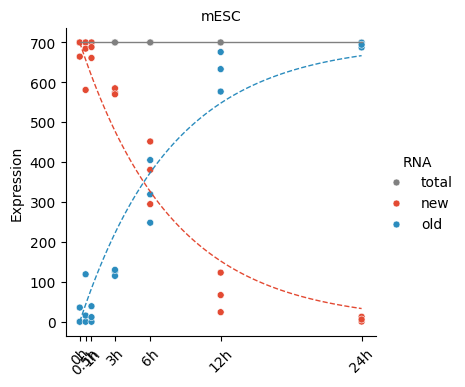

In [4]:
from grandpy import plot_gene_progressive_timecourse, plot_scatter

plot_gene_progressive_timecourse(dense, gene=(dense.get_genes("Dnmt3b", regex=True)[0]), fit_type="chase")

The curves represent the fitted model for this gene. Note that we do not specify the gene name directly, since here the gene names were labeled differently. `get_genes()` can be used to find genes using a regex:

In [5]:
dense.get_genes("Dnmt3b", regex=True)

['Dnmt3b.153687730']

In this step, we compare the half-life values obtained from `fit_kinetics()` with those from Herzog et al. The latter was estimated by observing the decrease in mismatches during the chase period, while our method also considers the GRAND-SLAM-estimated NTR and posterior. To compare, we add Herzog et al's half-live values to our analyses and create a scatter plot with half-life values on both the x and y axes. The plot clearly shows a correlation between the two sets of results, indicating that the `fit_kinetics()` results are consistent with those from Herzog et al.

In [6]:
# WORK IN PROGRESS - ?

t = pd.read_csv("https://zenodo.org/record/7612564/files/halflifes.tsv?download=1", sep="\t", header=0).assign(Gene=lambda df: df["Name"].astype(str) + "." + df["End"].astype(str))
t.set_index("Gene", inplace=True)
t.index.name = "Symbol"

dense = dense.with_analysis("kinetics", table=t)

print(dense.get_analyses(description=True))

{'kinetics_mESC': ['Synthesis', 'Half-life'], 'kinetics': ['Chromosome', 'Start', 'End', 'Name', 'Length', 'Strand', 'Half-life (h)', 'k (cpm/h)', 'stderror Half-life', 'stderror k', 'Rsquare']}


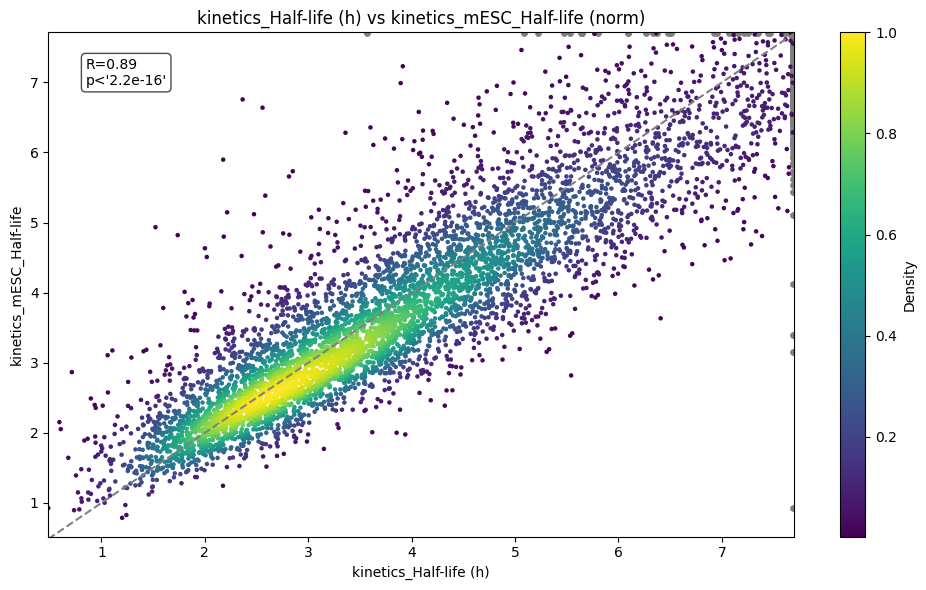

In [9]:
plot_scatter(dense, 'kinetics_Half-life (h)', 'kinetics_mESC_Half-life', correlation=gp.format_correlation(), diagonal=True)